# Scachepy - caching extension for Scanpy

This notebook shows the usage of Scachepy - a caching extension for Scanpy. What is does is basically pickles the result of an operation that takes too long to compute (or is required to be reproducible).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import scvelo as scv
import scachepy 
import tempfile

# Data loading and cache creation

In [3]:
handle = tempfile.TemporaryDirectory()
c = scachepy.Cache(handle.name, backend='pickle', separate_dirs=True)
c

Cache(root=/tmp/tmpzhupqmxd, ext='.pickle')

In [4]:
adata = sc.datasets.paul15()
adata.var_names_make_unique()

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, making a copy.


# Usage principles

In [5]:
c.pp.pca(adata, force=False, verbose=True)

No cache found in `pca.pickle`, computing values.


Difference between the `c.pp.pca` and `c.pp.pcarr` is that the former operates on `anndata.AnnData`, whereas the latter takes `np.ndarray` and caches only the `X_pca` attribute of `obsm`.

In [6]:
_ = c.pp.pcarr(adata.X)
_.shape

No cache found in `pca_arr.pickle`, computing values.


(2730, 50)

## Extra arguments

Each functions has some useful arguments:
+ `verbose=...` - be verbose (default: `True`)
+ `fname=...` - overrides the default filename
+ `force=...` - whether to force recaching (default: `False`)

In [7]:
c.pp.neighbors(adata, force=True, fname='foo', verbose=False)

We also need to specify the used `fname` to load it back again.

In [8]:
c.pp.neighbors(adata, fname='foo')

Loading data from: `foo.pickle`.


## Copy argument

These functions also work with `copy=True`, where applicable.

In [9]:
assert 'louvain' not in adata.uns

In [10]:
adata_louvain = c.tl.louvain(adata, copy=True)

No cache found in `louvain.pickle`, computing values.


In [11]:
assert 'louvain' not in adata.uns
assert 'louvain' in adata_louvain.uns

## Default functions

Caching functions usually cache the values based on their default function (and the keys specified). However, they can be used more flexibly, such as using a custom function (note that this example is just a demonstration):

In [12]:
def test(*args, **kwargs):
    print('Look Ma, no hands!')
    return sc.pp.log1p(args[0])

By default, `c.pp.expression` has no default function, but we can easily change that (the function needs to be supplied as the first argument, even before the `adata` object).

In [13]:
adata.X

array([[0., 0., 0., ..., 0., 2., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [1., 0., 3., ..., 2., 3., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [3., 0., 3., ..., 0., 1., 0.],
       [0., 0., 4., ..., 1., 1., 1.]], dtype=float32)

In [14]:
c.pp.expression(test, adata, force=True, fname='test')

Computing values (forced).
Look Ma, no hands!


In [15]:
c.pp.expression(adata, fname='test')

Loading data from: `test.pickle`.


The values have changed as expected. `anndata.Anndata` objects is either the first one in `args` or under key `adata` in `kwargs`.

In [16]:
adata.X

array([[0.       , 0.       , 0.       , ..., 0.       , 1.0986123,
        0.       ],
       [0.       , 0.       , 0.6931472, ..., 0.       , 0.6931472,
        0.       ],
       [0.6931472, 0.       , 1.3862944, ..., 1.0986123, 1.3862944,
        0.       ],
       ...,
       [0.       , 0.       , 0.6931472, ..., 0.       , 0.       ,
        0.       ],
       [1.3862944, 0.       , 1.3862944, ..., 0.       , 0.6931472,
        0.       ],
       [0.       , 0.       , 1.609438 , ..., 0.6931472, 0.6931472,
        0.6931472]], dtype=float32)

In [17]:
!ls $c.backend.dir

ls: cannot access '.backend.dir': No such file or directory


# Implemented caching functions

Here are all the functions which have caching version implemented. Future improvements will mostly likely be adding the default docstrings, and simplifying logic/refactoring the code and possibly adding support for `.h5ad` as storage backend.

In [18]:
list(c.pp)

['pcarr', 'expression', 'moments', 'pca', 'neighbors']

In [19]:
list(c.tl)

['louvain',
 'tsne',
 'umap',
 'diffmap',
 'paga',
 'velocity',
 'velocity_graph',
 'velocity_embedding',
 'draw_graph']

No cache found in `pca_plot.pickle`, computing values.


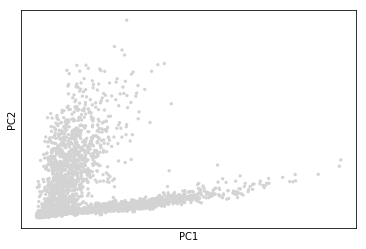

In [20]:
c.pl.pca(adata)

In [21]:
list(c.pl)

['clustermap',
 'correlation_matrix',
 'dendrogram',
 'diffmap',
 'dotplot',
 'dpt_groups_pseudotime',
 'dpt_timeseries',
 'draw_graph',
 'embedding_density',
 'filter_genes_dispersion',
 'heatmap',
 'highest_expr_genes',
 'highly_variable_genes',
 'matrix',
 'matrixplot',
 'paga',
 'paga_adjacency',
 'paga_compare',
 'paga_path',
 'pca',
 'pca_loadings',
 'pca_variance_ratio',
 'rank_genes_groups',
 'rank_genes_groups_dotplot',
 'rank_genes_groups_heatmap',
 'rank_genes_groups_matrixplot',
 'rank_genes_groups_stacked_violin',
 'rank_genes_groups_tracksplot',
 'rank_genes_groups_violin',
 'scatter',
 'sim',
 'stacked_violin',
 'tracksplot',
 'tsne',
 'umap',
 'violin']

## Creating caching functions

Creating new functions is relatively simple, as seen below. Note that `_cache1` is only present because `dict` needs to have unique keys, it gets stripped down down the line (it can be specified in other ways too, but this is the most convenient one).

In [22]:
c.pp.foo = c.pp.cache(dict(uns='pca',                                                                                                                                                                                      
                     uns_cache1='neighbors',                                                                                                                                                                         
                     obsm='X_pca',                                                                                                                                                                                   
                     varm='PCs',                                                                                                                                                                                     
                     layers='Ms',                                                                                                                                                                                    
                     layers_cache1='Mu'),                                                                                                                                                                            
                default_fn=scv.pp.moments,
                default_fname='moments')
c.pp.foo

<caching function of "scvelo.preprocessing.moments.moments">

In [23]:
help(c.pp.foo)

Help on FunctionWrapper in module scachepy.utils:

moments(...)
    Computes moments for velocity estimation.
    
    Arguments
    ---------
    data: :class:`~anndata.AnnData`
        Annotated data matrix.
    n_neighbors: `int` (default: 30)
        Number of neighbors to use.
    n_pcs: `int` (default: None)
        Number of principal components to use.
        If not specified, the full space is used of a pre-computed PCA,
        or 30 components are used when PCA is computed internally.
    mode: `'connectivities'` or `'distances'`  (default: `'connectivities'`)
        Distance metric to use for moment computation.
    method : {{'umap', 'gauss', 'hnsw', 'sklearn', `None`}}  (default: `'umap'`)
        Use 'umap' [McInnes18]_ or 'gauss' (Gauss kernel following [Coifman05]_
        with adaptive width [Haghverdi16]_) for computing connectivities.
    use_rep : `None`, `'X'` or any key for `.obsm` (default: None)
        Use the indicated representation. If `None`, the represe

In [24]:
c.pp.clear()

Deleting 4 files from `pp`.


In [25]:
c.clear(verbose=2)

Deleting 0 files from `pp`.
--------
Deleting 1 files from `tl`.
Deleting `louvain.pickle`.
--------
Deleting 1 files from `pl`.
Deleting `pca_plot.pickle`.
